# Lending Club Data Analysis and Modelling

## Looking in to the data and data cleaning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import networkx as nx

In [2]:
accepted_df = pd.read_csv('accepted_2007_to_2018q4.csv\\accepted_2007_to_2018Q4.csv')
accepted_df.head()

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term   
0  68407277        NaN     3600.0       3600.0           3600.0   36 months  \
1  68355089        NaN    24700.0      24700.0          24700.0   36 months   
2  68341763        NaN    20000.0      20000.0          20000.0   60 months   
3  66310712        NaN    35000.0      35000.0          35000.0   60 months   
4  68476807        NaN    10400.0      10400.0          10400.0   60 months   

   int_rate  installment grade sub_grade  ... hardship_payoff_balance_amount   
0     13.99       123.03     C        C4  ...                            NaN  \
1     11.99       820.28     C        C1  ...                            NaN   
2     10.78       432.66     B        B4  ...                            NaN   
3     14.85       829.90     C        C5  ...                            NaN   
4     22.45       289.91     F        F1  ...                            NaN   

  hardship_last_payment_amount disbursement_method  debt_settlement_flag   
0                          NaN                Cash                     N  \
1                          NaN                Cash                     N   
2                          NaN                Cash                     N   
3                          NaN                Cash                     N   
4                          NaN                Cash                     N   

  debt_settlement_flag_date settlement_status settlement_date   
0                       NaN               NaN             NaN  \
1                       NaN               NaN             NaN   
2                       NaN               NaN             NaN   
3                       NaN               NaN             NaN   
4                       NaN               NaN             NaN   

  settlement_amount settlement_percentage settlement_term  
0               NaN                   NaN             NaN  
1               NaN                   NaN             NaN  
2               NaN                   NaN             NaN  
3               NaN                   NaN             NaN  
4               NaN                   NaN             NaN  

[5 rows x 151 columns]

In [3]:
accepted_df.duplicated().sum()

0

Looks like we have 151 features in our dataset

In [4]:
missing_values = pd.DataFrame(accepted_df.isnull().sum().sort_values(ascending=False), columns=['Number of missing values'])
missing_values.head(10)

Number of missing values
member_id                                                    2260701
orig_projected_additional_accrued_interest                   2252050
hardship_end_date                                            2249784
hardship_start_date                                          2249784
hardship_type                                                2249784
hardship_reason                                              2249784
hardship_status                                              2249784
deferral_term                                                2249784
hardship_last_payment_amount                                 2249784
hardship_payoff_balance_amount                               2249784

There are many columns in the dataset which have many missing values, since imputing values of such amount of missing values will cause false data points which are not good for modelling, let's remove columns which have missing values of above 100,000.

In [5]:
the_bad_ones = missing_values[missing_values['Number of missing values'] >= 100000]

We have collected all the unwanted columns now let's remove them.

In [6]:
accepted_df = accepted_df.drop(the_bad_ones.index, axis=1)

In [7]:
len(accepted_df.columns.to_list())

88

Now the number of features have been reduced from 151 to 88.

In [8]:
accepted_df.isnull().sum().sort_values(ascending=False)

bc_util                    76104
percent_bc_gt_75           75412
bc_open_to_buy             74968
mths_since_recent_bc       73445
pct_tl_nvr_dlq             70464
                           ...  
collection_recovery_fee       33
last_pymnt_amnt               33
loan_amnt                     33
last_fico_range_low           33
id                             0
Length: 88, dtype: int64

There are still some missing values, let's handle them by removing rows with misssing values since most columns have a similar type of missing values throughout.

In [9]:
accepted_df.dropna(inplace=True)

In [10]:
accepted_df.isnull().sum().sort_values(ascending=False)

id                       0
loan_amnt                0
num_accts_ever_120_pd    0
mths_since_recent_bc     0
mort_acc                 0
                        ..
pub_rec                  0
open_acc                 0
inq_last_6mths           0
fico_range_high          0
debt_settlement_flag     0
Length: 88, dtype: int64

Now we can see that we have no missing values in the dataset.

In [11]:
accepted_df.drop('id', axis=1, inplace=True)

Removing the unnecessary 'id' column.

In [12]:
df_raw = accepted_df.copy()

In [13]:
useless_cols = ['url', 'issue_d', 'title', 'zip_code', 'debt_settlement_flag',
                'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
                'last_fico_range_high', 'last_fico_range_low', 'addr_state', 'funded_amnt', 'funded_amnt_inv']

The above list of useless columns list was generated by looking into the [data dictionary](https://docs.google.com/spreadsheets/d/1Pb0nkSk4fqMOGbgRnd-oiegTSceyg5szY3v7VEG7RjU/edit?usp=sharing) for the dataset. Some of the columns are not necessary for modelling and some of the informations are not necessary for analysis.

I have saved the dataframe prior to the removal so that we can use some of the data for the analysis.

In [14]:
accepted_df.drop(useless_cols, axis=1, inplace=True)

Now the above columns have been removed.

In [15]:
num_cols = accepted_df.dtypes[~(accepted_df.dtypes == 'object')].index

Now let's extract the numerical columns and try to see correlation among features.

In [16]:
corr = accepted_df[num_cols].corr()
corr = corr.abs().unstack()
corr = corr.sort_values(kind="quicksort", ascending=False)
corr = corr[corr >= 0.7]
corr = corr[corr < 1]
corr = pd.DataFrame(corr).reset_index()
corr.columns = ['feature1', 'feature2', 'corr']

We have taken features who have an absolute value correlation coefficient of above 0.7

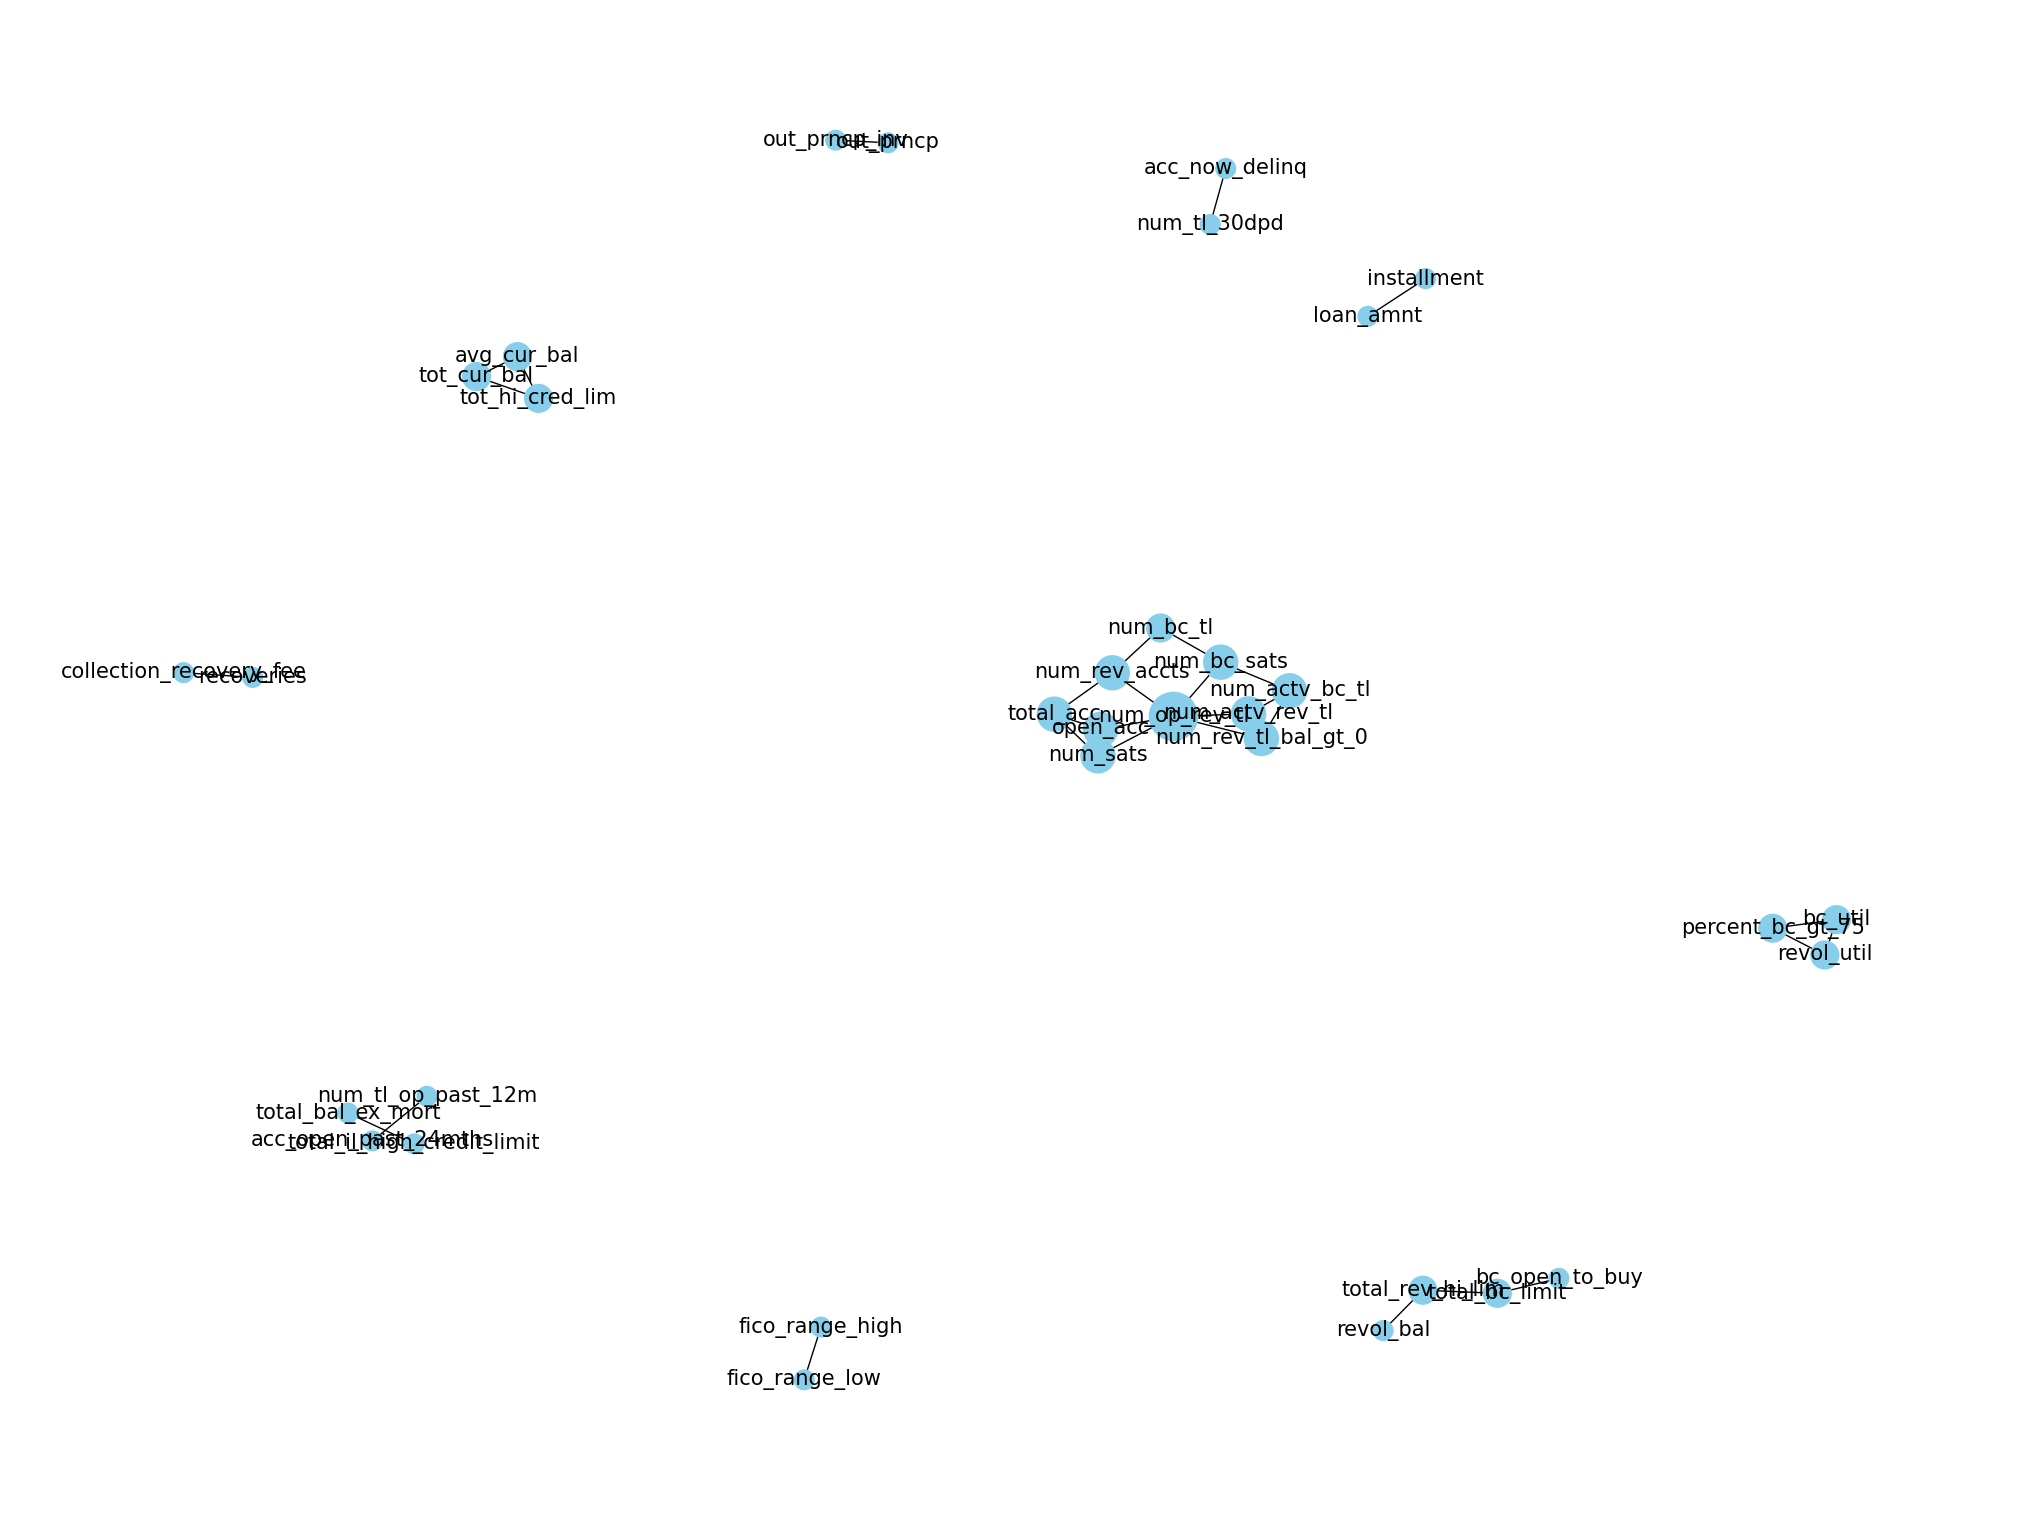

In [17]:
from collections import defaultdict

correlation_count = defaultdict(int)
for feature in corr['feature1']:
    correlation_count[feature] += 1
for feature in corr['feature2']:
    correlation_count[feature] += 1

# sort by correlation count
sorted_correlation_count = sorted(correlation_count.items(), key=lambda x: x[1], reverse=True)

# plot a dependency graph
G = nx.Graph()
for feature, count in sorted_correlation_count:
    G.add_node(feature, weight=count)
for i in range(len(corr)):
    G.add_edge(corr['feature1'][i], corr['feature2'][i])
plt.figure(figsize=(20, 15))
nx.draw(G, with_labels=True, node_size=[G.nodes[node]['weight']*100 for node in G], node_color='skyblue', font_size=15)
plt.show()

The above graph is a dependency graph showing which features are correlated to which and what the correlation clusters, to see whcih column to remove so that the other correlations are reduced.

After looking into the data dictionary and which features have many correlated features associated with them.

I selected the columns: *num_op_rev_tl, installment, total_il_high_credit_limit, total_bc_limit, total_rev_hi_lim, num_tl_30dpd, out_prncp_inv, num_tl_op_past_12m, collection_recovery_fee, recoveries, bc_util, tot_hi_cred_lim, tot_cur_bal, percent_bc_gt_75, num_actv_bc_tl, total_acc, num_bc_tl, num_rev_tl_bal_gt_0, num_actv_rev_tl, num_sats*

In [18]:
accepted_df.drop(['num_op_rev_tl', 'installment', 'total_il_high_credit_limit', 'total_bc_limit', 'total_rev_hi_lim', 'num_tl_30dpd', 'out_prncp_inv', 'num_tl_op_past_12m', 'collection_recovery_fee', 'recoveries', 'bc_util', 'tot_hi_cred_lim', 'tot_cur_bal', 'percent_bc_gt_75', 'num_actv_bc_tl', 'total_acc', 'num_bc_tl', 'num_rev_tl_bal_gt_0', 'num_actv_rev_tl', 'num_sats'], axis=1, inplace=True)

In [19]:
rejected_df = pd.read_csv('rejected_2007_to_2018q4.csv\\rejected_2007_to_2018Q4.csv')

In [20]:
rejected_df.head()

Amount Requested Application Date                        Loan Title   
0            1000.0       2007-05-26  Wedding Covered but No Honeymoon  \
1            1000.0       2007-05-26                Consolidating Debt   
2           11000.0       2007-05-27       Want to consolidate my debt   
3            6000.0       2007-05-27                           waksman   
4            1500.0       2007-05-27                            mdrigo   

   Risk_Score Debt-To-Income Ratio Zip Code State Employment Length   
0       693.0                  10%    481xx    NM           4 years  \
1       703.0                  10%    010xx    MA          < 1 year   
2       715.0                  10%    212xx    MD            1 year   
3       698.0               38.64%    017xx    MA          < 1 year   
4       509.0                9.43%    209xx    MD          < 1 year   

   Policy Code  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0

## EDA

In [21]:
from ydata_profiling import ProfileReport

This might not render on browser based displays

In [22]:
profile = ProfileReport(accepted_df, minimal=True)
profile.to_file("output.html")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Above I have used an auto EDA tool, to do basic EDA for the many features we have in the dataset. So that I can get some insight into which features to do more EDA at.

### EDA based on some questions

I have picked the loan_status column to be the feature I will use for prediction.

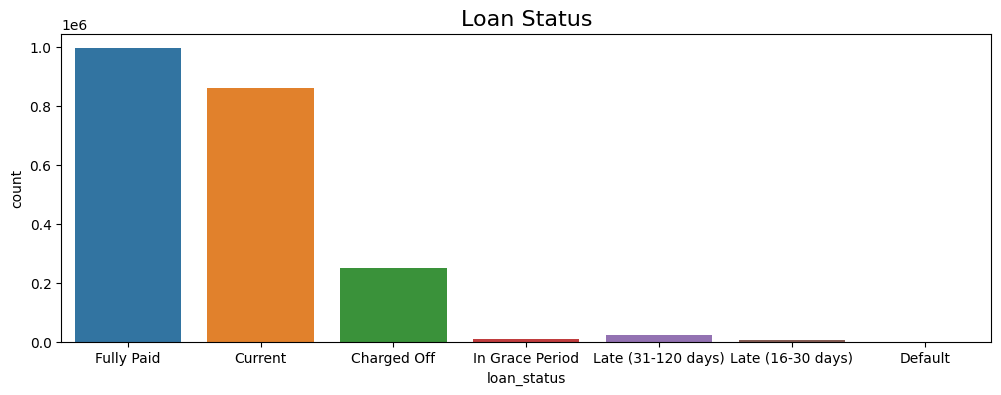

In [23]:
plt.figure(figsize=(12,4))
sns.countplot(x='loan_status', data=accepted_df)
plt.title('Loan Status', fontsize=16)
plt.show()

There are many fully paid loan statuses next to it being Current.

Below is the meaning of all loan statuses:
- **Fully Paid** - the loan has been fully repaid, either at the end of the loan term or earlier because of prepayment.
- **Current** - the loan is up to date on all outstanding payments.
- **Charged Off** - LendingClub charges off a loan when we no longer reasonably expect further payments. Generally, charge-offs occur no later than 30 days after the loan enters Default status. Once a loan is charged off, the remaining principal balance of the Note is deducted from the account balance.
- **In Grace Period** - the loan is past due but within the 15-day grace period. LendingClub sends reminders to the member that their loan payment is past due.
- **Late (31–120)** - the loan hasn’t been current for 31–120 days. This is the second tranche of loan delinquency.
- **Late (16-30)** - the loan hasn’t been current for 16–30 days. This is the first tranche of loan delinquency.
- **Default** - the loan has not been current for more than 120 days. A loan in default status still appears in your Notes, but at this point, in most cases, LendingClub will begin the process to charge off the loan.

Debt-to-Income Influence on loan statuses.

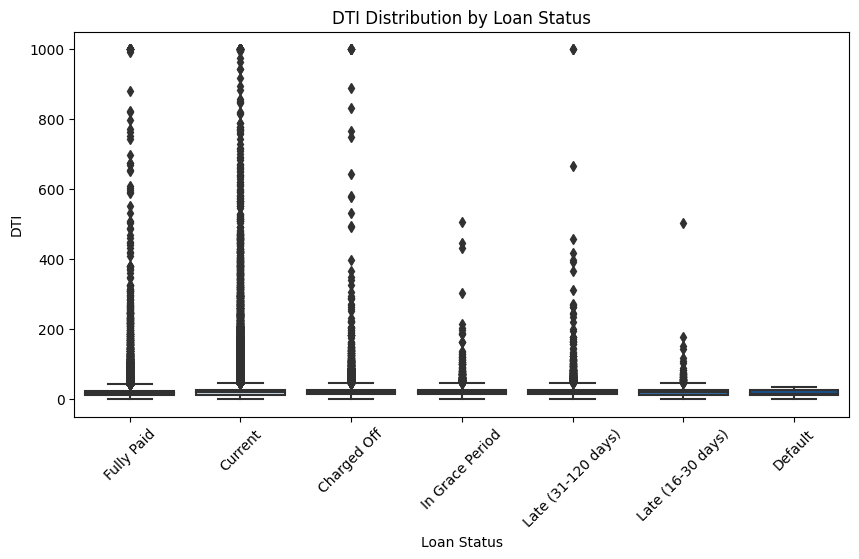

In [24]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=accepted_df, x='loan_status', y='dti', palette='Blues')
plt.title('DTI Distribution by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('DTI')
plt.xticks(rotation=45)
plt.show()

Higher DTI ratio doesn't necessarily mean we will get a fully paid loan status at the end of the day, beacuase we are also seeing some higher DTI ratios to charged off loans.

How is loan grade related to the different loan statuses.

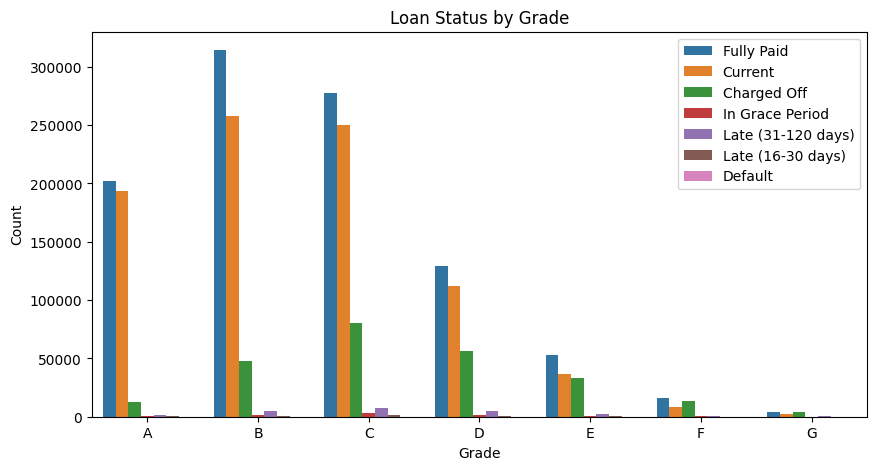

In [25]:
plt.figure(figsize=(10,5))
grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
sns.countplot(data=accepted_df, x='grade', hue='loan_status', order=grade_order)
plt.title('Loan Status by Grade')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()

As the loan grades increase the number of Charged off loan statuses also increase, which shows higher loan grade values are actually riskier.

installments vs loan status
"installment" refers to a scheduled payment that a borrower makes to repay their loan. Installments are regular, fixed payments that borrowers agree to make at specific intervals, typically on a monthly basis, until the loan is fully repaid.

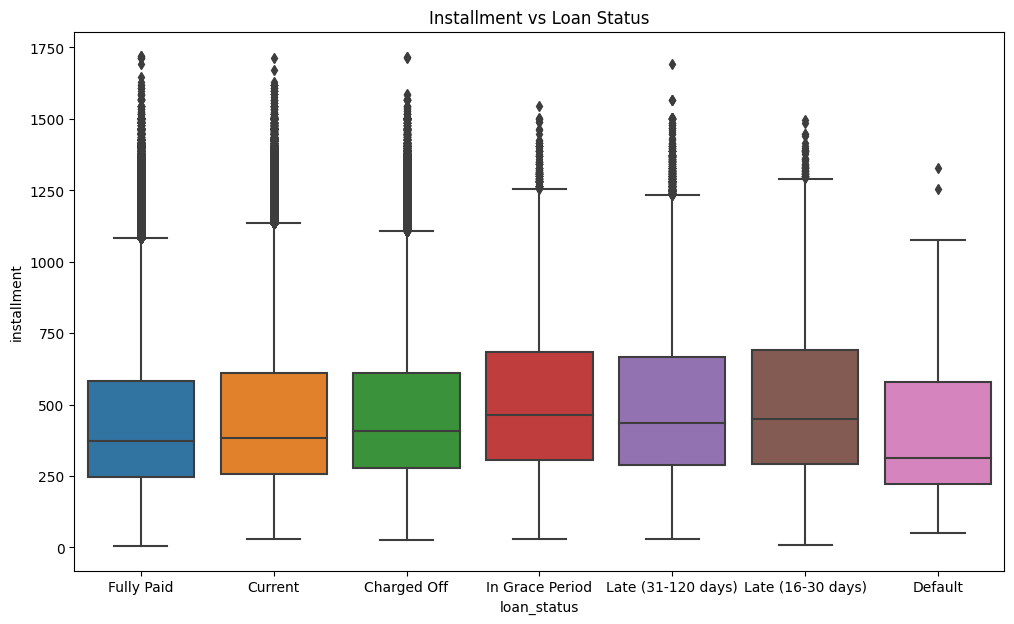

In [26]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='loan_status', y='installment', data=df_raw)
plt.title('Installment vs Loan Status')
plt.show()

Installment fees look a little higher on In Grace period and Late statuses.

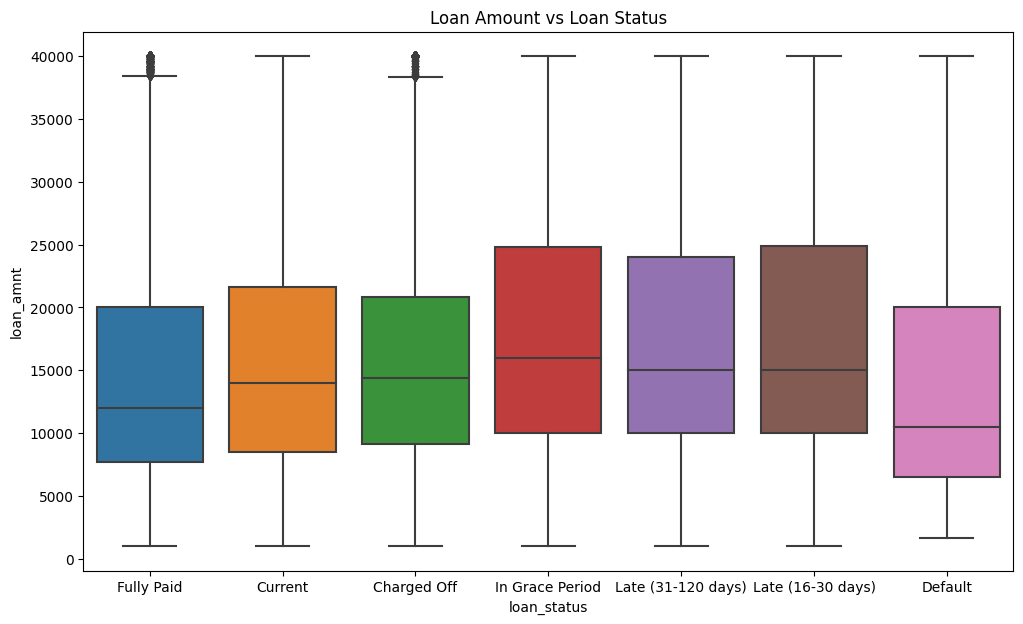

In [27]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='loan_status', y='loan_amnt', data=df_raw)
plt.title('Loan Amount vs Loan Status')
plt.show()

Here as well loan statuses like In grace period and Late received higher loan amounts.

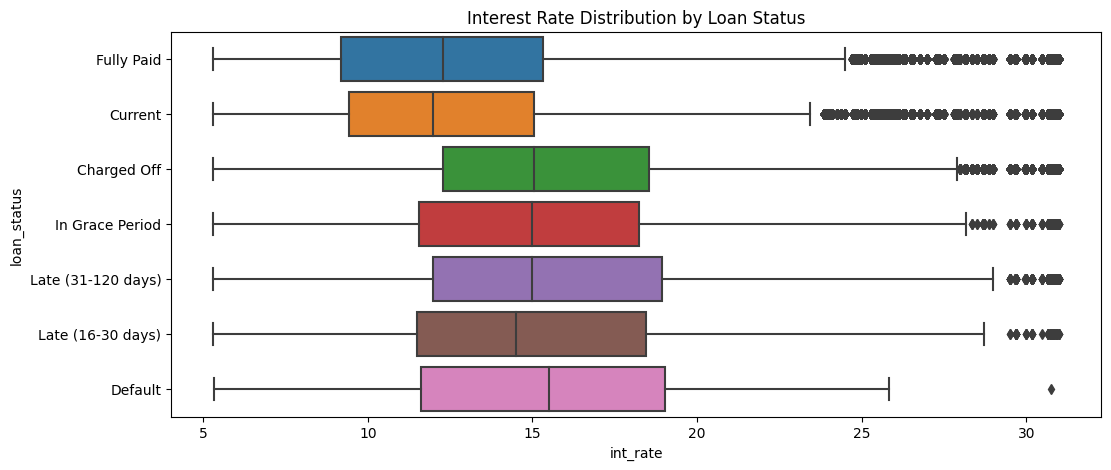

In [30]:
plt.figure(figsize=(12,5))
sns.boxplot(x=df_raw.int_rate, y=df_raw.loan_status.astype(str))
df_raw.groupby(['loan_status'])['int_rate'].describe()
plt.title('Interest Rate Distribution by Loan Status')
plt.show()

Apart from Fully paid and Current loan statuses, other loan statuses have higher interest rates.

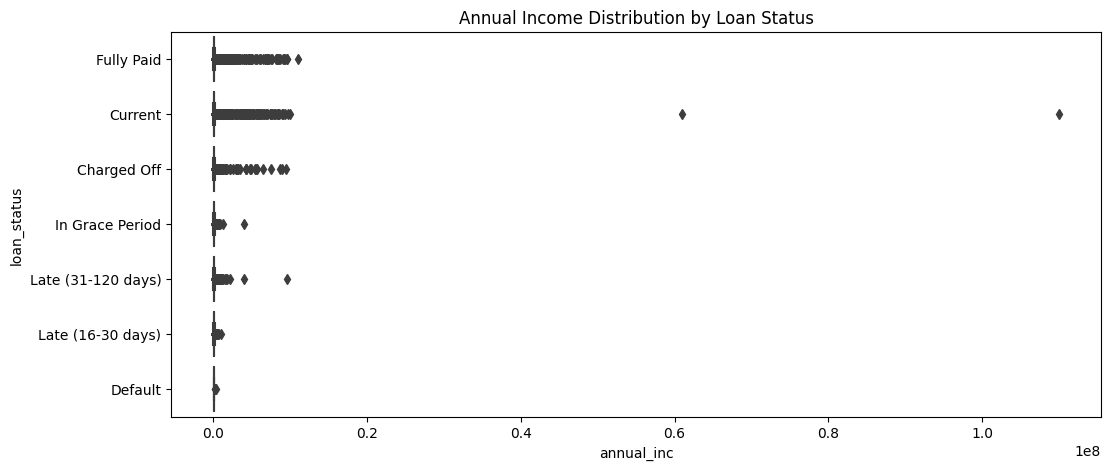

In [29]:
plt.figure(figsize=(12,5))
sns.boxplot(x=df_raw.annual_inc, y=df_raw.loan_status.astype(str))
df_raw.groupby(['loan_status'])['annual_inc'].describe()
plt.title('Annual Income Distribution by Loan Status')
plt.show()

Looking at the above plot we can see that Annual Incomes are higher on Fully Paid, Current, and Charges off loan statuses which does not give us a clear distinction between the different loan statuses.

Geographical Impact: Is there a synergistic relationship between borrower location and loan outcomes?

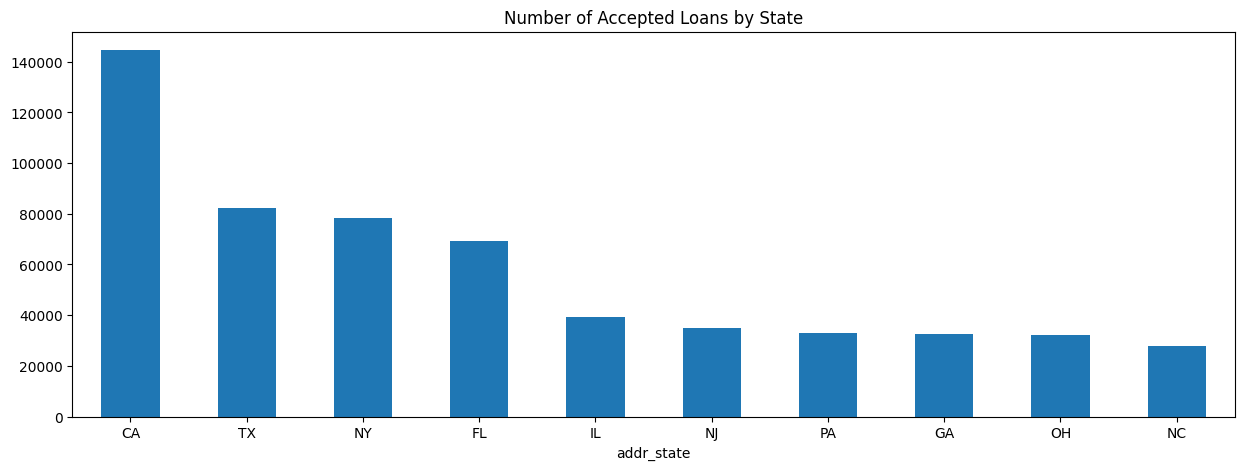

In [31]:
accepted_loans = df_raw[df_raw['loan_status'] == 'Fully Paid'].groupby('addr_state').count().sort_values(ascending=False, by='zip_code')['zip_code']
accepted_loans.head(10).plot(kind='bar', figsize=(15, 5), title='Number of Accepted Loans by State')
plt.xticks(rotation=0)
plt.show()

We see that there are more accepted loans in the state California.

What is the distribution of loan amounts and interest rates across different states? 

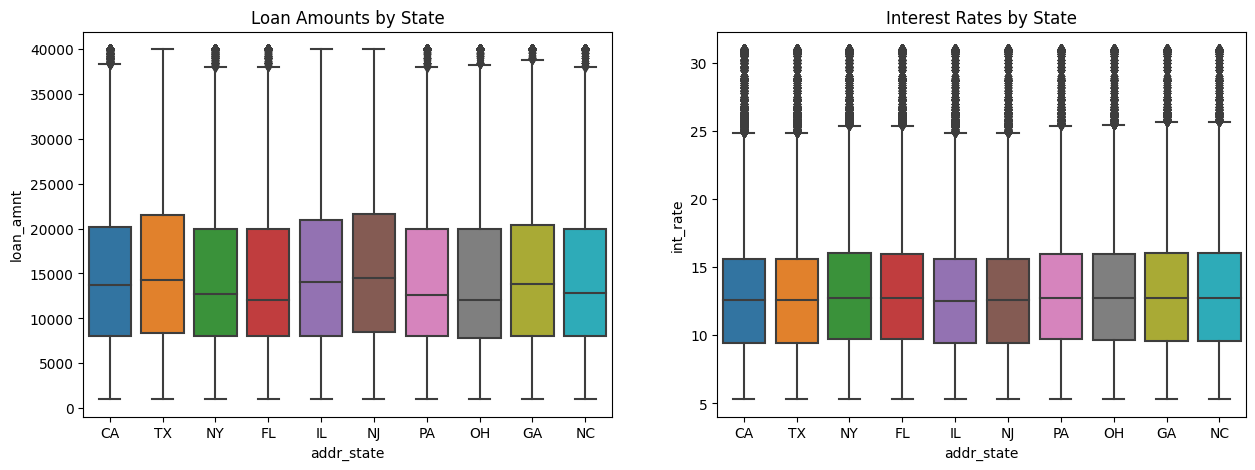

In [32]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='addr_state', y='loan_amnt', data=df_raw, order=df_raw['addr_state'].value_counts().sort_values(ascending=False).iloc[:10].index)
plt.title('Loan Amounts by State')
plt.subplot(1, 2, 2)
sns.boxplot(x='addr_state', y='int_rate', data=df_raw, order=df_raw['addr_state'].value_counts().sort_values(ascending=False).iloc[:10].index)
plt.title('Interest Rates by State')
plt.show()

For loan amounts it looks mostly similar for all the states we see here. Altough there are even more higher loan amount for some states.

For interset rate by state we can also say that it mostly similar for the states we see here.

Interest Rate and Loan Grade Connection: How do borrower attributes (e.g., credit score, income) synergize with loan grade to determine the interest rate? Are there instances where certain borrower segments receive more favorable rates for the same loan grade?

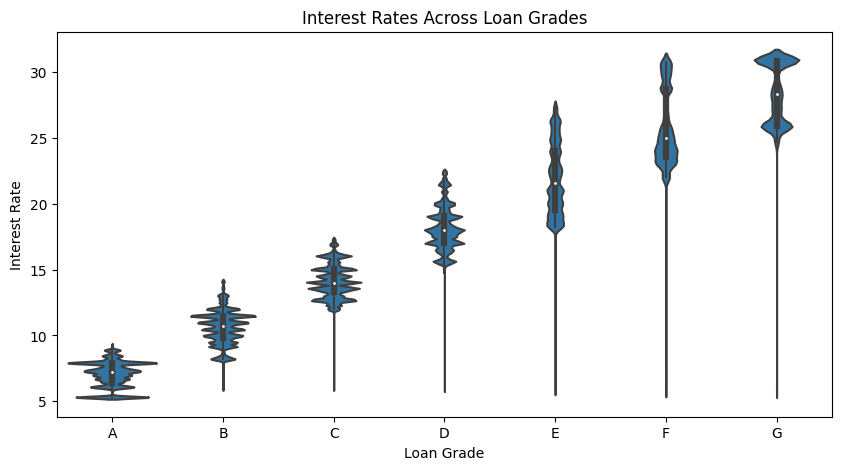

In [33]:
plt.figure(figsize = [10, 5])
base_color = sns.color_palette()[0]
grade_order = ['A','B','C','D','E','F','G']
sns.violinplot(data = accepted_df, x = 'grade', y = 'int_rate', color = base_color, order = grade_order)
plt.xlabel('Loan Grade')
plt.ylabel('Interest Rate')
plt.title('Interest Rates Across Loan Grades')
plt.show()

We can see that as loan grades increase interest rate also increases, which shows higher loan status will have higher interest rates. Usually lower loan grades are less risky and show lower loss rates.

How does the interest rate vary with the loan grade and term? 

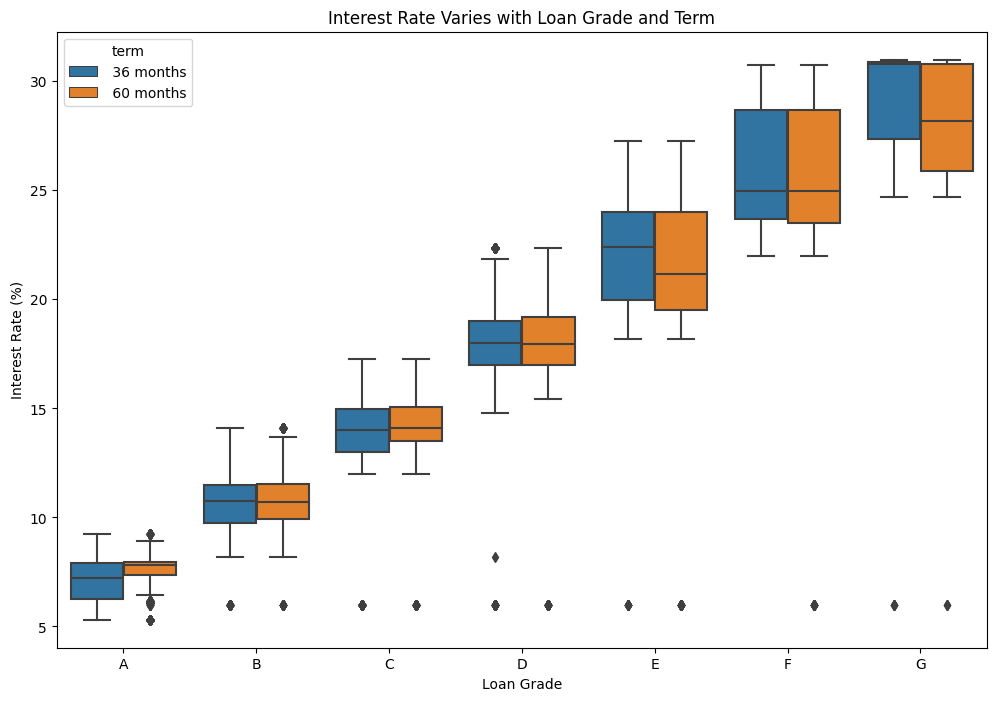

In [34]:
plt.figure(figsize=(12, 8))
grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
sns.boxplot(x='grade', y='int_rate', hue='term', data=accepted_df, order=grade_order)
plt.title('Interest Rate Varies with Loan Grade and Term')
plt.xlabel('Loan Grade')
plt.ylabel('Interest Rate (%)')
plt.show()

As we can see from the diagram above as the laon grades keep on increasing the term 60 months increases gradually, which confirms the above plots information higher loan grades are actually worse.

How does the borrower's credit score affect the loan amount? 

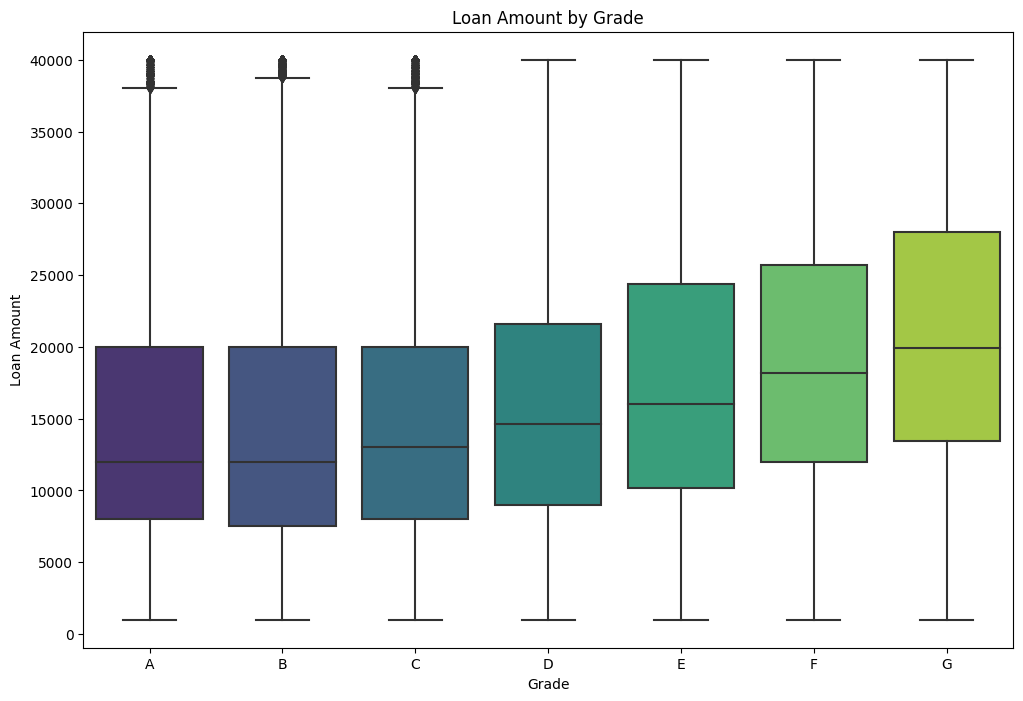

In [35]:
plt.figure(figsize=(12, 8))
grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
sns.boxplot(x='grade', y='loan_amnt', data=accepted_df, palette='viridis', order=grade_order)
plt.title('Loan Amount by Grade')
plt.xlabel('Grade')
plt.ylabel('Loan Amount')
plt.show()

Surprisingly in the above plot we see that higher loan grades recieve higher amounts of loans even though they are the riskier type of borrowers.

What is the distribution of loan amounts and interest rates for different loan terms? 

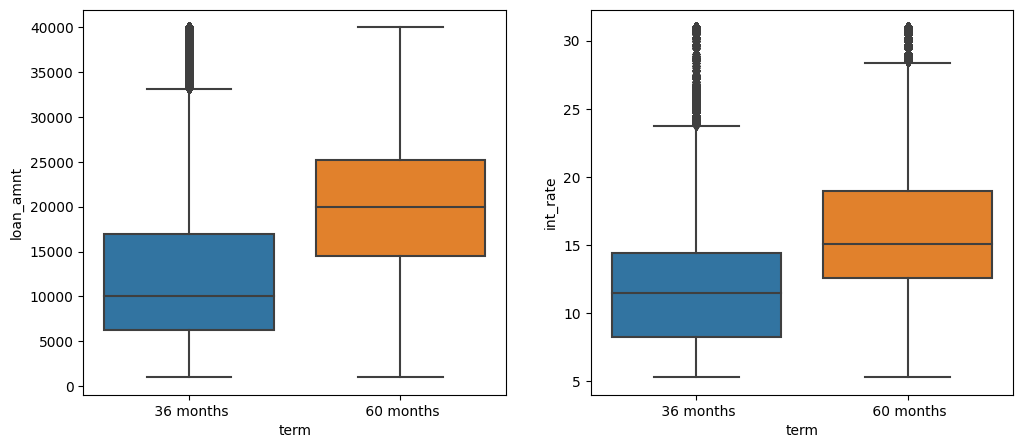

In [36]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='term', y='loan_amnt', data=accepted_df)
plt.subplot(1, 2, 2)
sns.boxplot(x='term', y='int_rate', data=accepted_df)
plt.show()

From the above plots we can see that longer loan terms have higher loan amounts and at the same time higher interest rates as well.

A payment plan refers to the structured schedule of payments that a borrower agrees to when they take out a loan in lending club.

"n": This typically stands for "no" or "none." It generally indicates that a particular feature or option is not present or not applicable to the loan. 

"y": This stands for "yes. "y" indicates that a particular feature or option is present or applicable to the loan. 

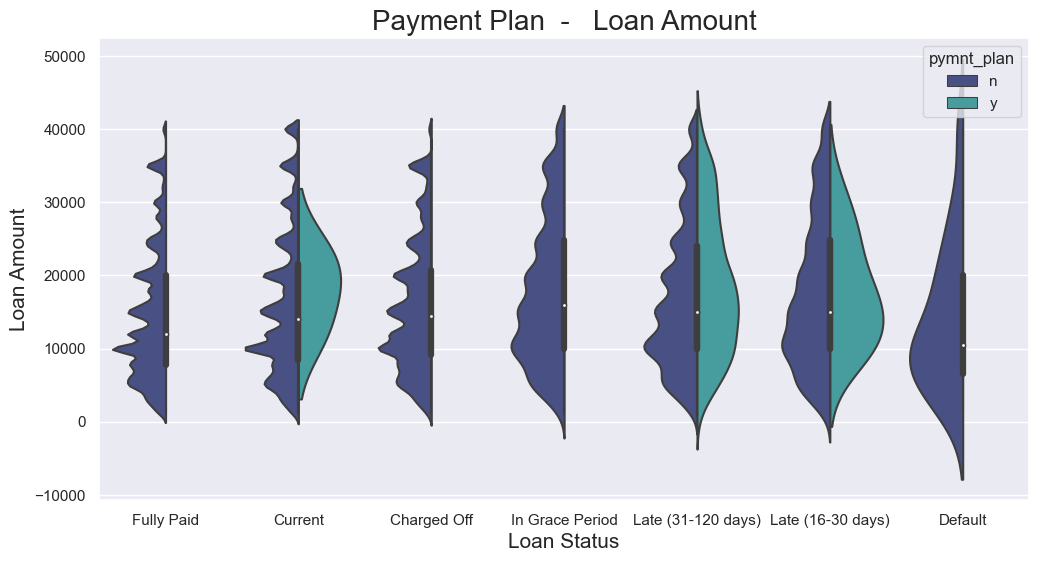

In [37]:
sns.set(rc={'figure.figsize':(12,6)})
sns.violinplot(x='loan_status',y='loan_amnt',data=accepted_df, hue='pymnt_plan', split=True,palette='mako')
plt.title(str('Payment Plan')+"  -   "+str('Loan Amount'), fontsize=20)
plt.xlabel('Loan Status', fontsize=15)
plt.ylabel('Loan Amount', fontsize=15)
plt.show()

Above we can see that most loan statuses have no payment plan associated with them, and for most loan amounts we can also see that there are not many payment plans.

In LendingClub, a "hardship flag" refers to a status that can be applied to a loan when a borrower is experiencing financial difficulties or facing hardships that make it challenging for them to meet their loan obligations as originally agreed.

"Y" (Yes) Hardship Flag: When a borrower is facing financial challenges and has entered into a hardship plan with LendingClub, the "Y" flag is applied to their account. 

"N" (No) Hardship Flag: If a borrower is not enrolled in a hardship plan and is making regular payments according to the original loan terms.

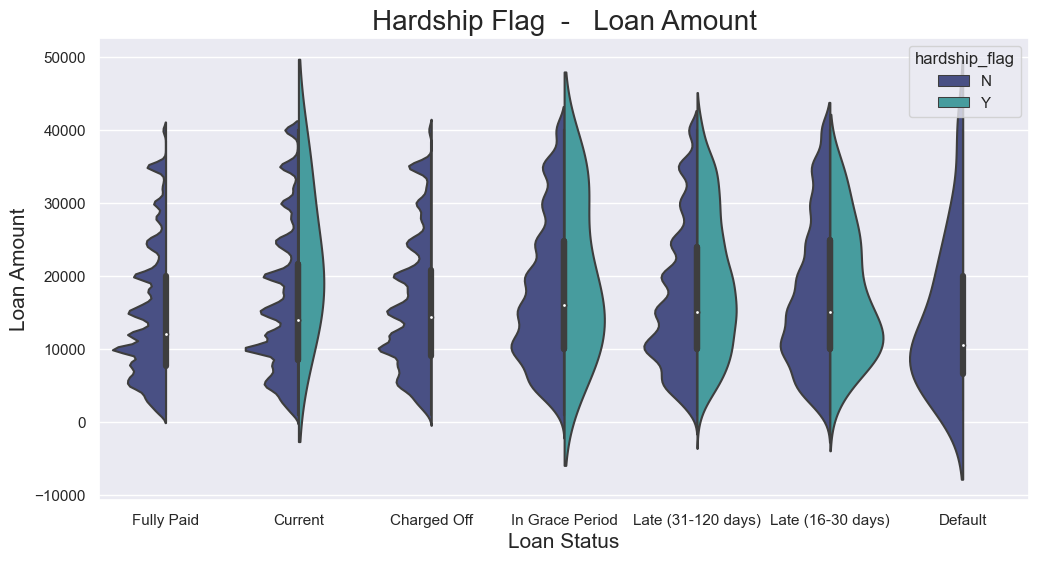

In [38]:
sns.set(rc={'figure.figsize':(12,6)})
sns.violinplot(x='loan_status',y='loan_amnt',data=accepted_df, hue='hardship_flag', split=True,palette='mako')
plt.title(str('Hardship Flag')+"  -   "+str('Loan Amount'), fontsize=20)
plt.xlabel('Loan Status', fontsize=15)
plt.ylabel('Loan Amount', fontsize=15)
plt.show()

Above we see more yes's on the laon statuses In Grace Period, and Late which makes sense that people who have hardship flags associated to thier loans are either in a grace perios or late. For loan amounts we don't see that much of a significant difference.

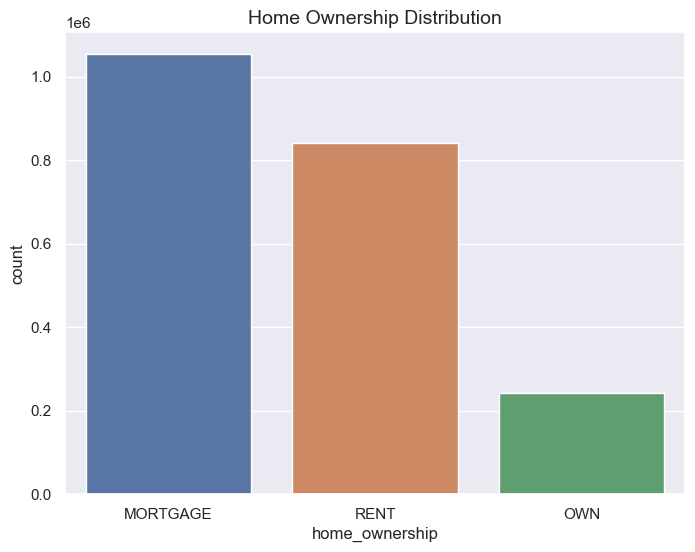

In [39]:
plt.figure(figsize=(8, 6))
sns.countplot(x='home_ownership', data=df_raw[df_raw['home_ownership'].isin(['MORTGAGE', 'RENT', 'OWN'])])
plt.title('Home Ownership Distribution', fontsize=14)
plt.show()

Mortgage: When a borrower has a "Mortgage," it means they own a home and have taken out a loan (mortgage) to finance the purchase of that home. 

Rent: If a borrower is "Renting," it means they do not own a home and are paying to live in a property owned by someone else. 

Own: "Own" refers to the situation where a borrower owns their home outright without any mortgage or loan associated with it.

Above we see that most people have mortgaged thier homes for loan.

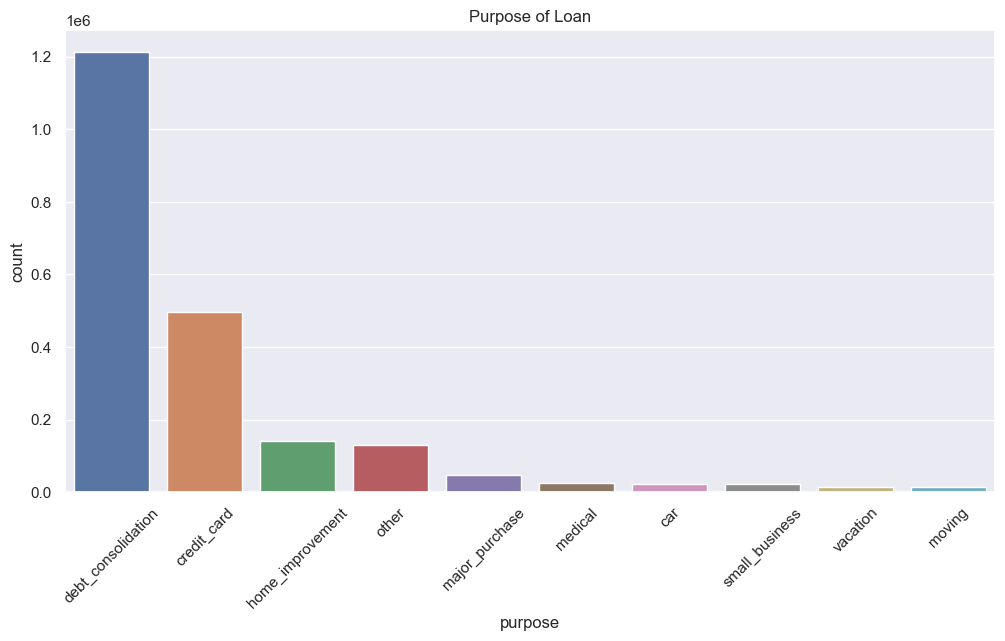

In [40]:
sns.countplot(x='purpose', data=df_raw, order=df_raw['purpose'].value_counts().index[:10])
plt.xticks(rotation=45)
plt.title('Purpose of Loan')
plt.show()

Majority of the loan purposes in this dataset are of the purpose of Consolidating an existing loan, which shows many borrowers, borrow again to pay existing debts.

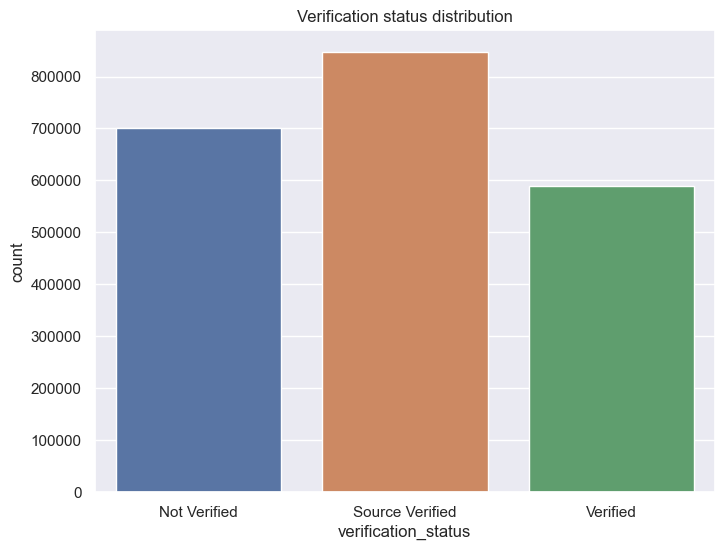

In [41]:
plt.figure(figsize=(8,6))
sns.countplot(x='verification_status', data=df_raw)
plt.title('Verification status distribution')
plt.show()

Most individuals are source verified in this dataset which refers to the lender has receiving and verifying documentation directly from the source of the information. 

Can we identify a combination of borrower attributes that consistently leads to a loan being fully paid?

Let's use :
- loan_amnt: The loan amount requested by the borrower. Higher loan amounts might be associated with higher risk and more stringent approval criteria.
- term: The length of the loan term (e.g., 36 months or 60 months). Longer terms might lead to different approval rates and outcomes.
- int_rate: The interest rate assigned to the loan. This could be a key factor in loan affordability and repayment.
- grade and sub_grade: Lending Club's assigned loan grade and subgrade. These reflect the risk assessment of the borrower and could play a role in approval rates.
- annual_inc: The borrower's annual income. Higher income might indicate better ability to repay the loan.
- verification_status: Indicates whether the borrower's income has been verified by Lending Club.
- purpose: The purpose for which the loan is being taken. Different loan purposes could have varying default rates.

In [ ]:
cols = ['loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade', 'annual_inc', 'verification_status', 'purpose', 'loan_status']
attrs_df = df_raw[cols].copy()

attrs_df = pd.get_dummies(attrs_df, columns=['term', 'grade', 'sub_grade', 'verification_status', 'purpose', 'loan_status'])

corr = attrs_df.corr()

corr['loan_status_Fully Paid'].sort_values(ascending=False).head(10)

loan_status_Fully Paid          1.000000
term_ 36 months                 0.177484
grade_B                         0.045435
verification_status_Verified    0.037956
sub_grade_B3                    0.030267
sub_grade_A5                    0.028597
grade_A                         0.025824
sub_grade_B2                    0.020444
sub_grade_B1                    0.016037
purpose_debt_consolidation      0.016005
Name: loan_status_Fully Paid, dtype: float64

We don't really see a relationship between loan status and the other features we checked its correlation against.

## Statistical Inference

In [43]:
from functions import perform_statistical_tests, print_results

- Null Hypothesis (H0): The average interest rate for fully paid loans is the same as the average interest rate for charged-off loans.
- Alternative Hypothesis (H1): The average interest rate for fully paid loans is different from the average interest rate for charged-off loans.

In [44]:
population1 = df_raw[df_raw['loan_status'] == 'Fully Paid']['int_rate']
population2 = df_raw[df_raw['loan_status'] == 'Charged Off']['int_rate']

alpha = 0.05
results = perform_statistical_tests(population1, population2, alpha)

print_results(results)

t-test results:
{'t-statistic': -285.01840835006686, 'p-value': 0.0, 'hypothesis': 'Rejected'}

z-test results:
{'z-statistic': -298.5586377548219, 'p-value': 0.0, 'hypothesis': 'Rejected'}

Confidence interval for population1: (12.624392260777801, 12.64226717518826)
Confidence interval for population2: (15.712509117074195, 15.751193971721648)


- Null Hypothesis (H0): There is no significant difference in the loan amounts between different loan grades (e.g., A, B, C, etc.).
- Alternative Hypothesis (H1): There is a significant difference in the loan amounts between different loan grades.
Features: grade, loan_amnt (loan amount).

In [45]:
population1 = df_raw[df_raw['grade'] == 'A']['loan_amnt']
population2 = df_raw[df_raw['grade'] == 'B']['loan_amnt']

alpha = 0.05
results = perform_statistical_tests(population1, population2, alpha)

print_results(results)

t-test results:
{'t-statistic': 28.35268991112626, 'p-value': 9.348320667375177e-177, 'hypothesis': 'Rejected'}

z-test results:
{'z-statistic': 28.45117195651029, 'p-value': 4.713079011694164e-178, 'hypothesis': 'Rejected'}

Confidence interval for population1: (14795.813907807786, 14851.833086447821)
Confidence interval for population2: (14283.903108406, 14328.443914619842)


- Null Hypothesis (H0): The average annual income of borrowers with a home ownership status of "OWN" is the same as the average annual income of borrowers with a home ownership status of "RENT".
- Alternative Hypothesis (H1): The average annual income of borrowers with a home ownership status of "OWN" is different from the average annual income of borrowers with a home ownership status of "RENT".

In [46]:
population1 = df_raw[df_raw['home_ownership'] == 'OWN']['annual_inc']
population2 = df_raw[df_raw['home_ownership'] == 'RENT']['annual_inc']

alpha = 0.05
results = perform_statistical_tests(population1, population2, alpha)

print_results(results)

t-test results:
{'t-statistic': 26.879661782823202, 'p-value': 4.684313838236261e-159, 'hypothesis': 'Rejected'}

z-test results:
{'z-statistic': 21.054489919647967, 'p-value': 2.0801037418475444e-98, 'hypothesis': 'Rejected'}

Confidence interval for population1: (72941.53888697719, 73619.14692789412)
Confidence interval for population2: (66891.26793375057, 67467.81786974006)


In [47]:
'''
Null Hypothesis (H0): The average debt-to-income (DTI) ratio for loans with different loan purposes (e.g., debt consolidation, credit card, etc.) is the same.
Alternative Hypothesis (H1): The average debt-to-income (DTI) ratio for loans with different loan purposes is different.
Features: purpose (loan purpose), dti (debt-to-income ratio).
'''

population1 = df_raw[df_raw['purpose'] == 'debt_consolidation']['dti']
population2 = df_raw[df_raw['purpose'] == 'credit_card']['dti']

alpha = 0.05
results = perform_statistical_tests(population1, population2, alpha)

print_results(results)

t-test results:
{'t-statistic': 19.638625428877123, 'p-value': 7.532829827697242e-86, 'hypothesis': 'Rejected'}

z-test results:
{'z-statistic': 19.69375821919098, 'p-value': 2.4390449767058898e-86, 'hypothesis': 'Rejected'}

Confidence interval for population1: (19.56148930386161, 19.612272470078754)
Confidence interval for population2: (19.072981193026404, 19.15280611508879)


## Feature Engineering

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report, precision_score, recall_score, f1_score
from sklearn.mixture import GaussianMixture

import xgboost as xgb
import catboost as cb
import optuna
import joblib
import shap
import lime

Let's grab the categorical features

In [22]:
cat_features = []
for col in accepted_df.columns:
    if accepted_df[col].dtype == 'object':
        cat_features.append(col)

Let's only take the features that are necessary for one hot encoding

In [23]:
wanted = cat_features.copy()
wanted = [item for item in wanted if item not in ['purpose', 'sub_grade', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d', 'loan_status']]

Let's drop those features

In [24]:
accepted_df = accepted_df.drop(['purpose', 'sub_grade', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d'], axis=1)

Now from the target class we will only take the Fully Paid and Charged Off loan statuses. For prediction.

- **Fully Paid** - the loan has been fully repaid, either at the end of the loan term or earlier because of prepayment.
- **Charged Off** - LendingClub charges off a loan when we no longer reasonably expect further payments. Generally, charge-offs occur no later than 30 days after the loan enters Default status. Once a loan is charged off, the remaining principal balance of the Note is deducted from the account balance.

In [25]:
accepted_df = accepted_df[accepted_df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

In [26]:
X = accepted_df.drop('loan_status', axis=1)
y = accepted_df['loan_status']

Splitting our target from the rest.

Now we take the features we wanted and we encode them using one hot encoding

In [27]:
dummy_features = X[wanted]

In [28]:
one_hot_encoded = pd.get_dummies(dummy_features)

Now we will drop the original columns since we have the one hot encoded once.

In [29]:
X.drop(wanted, axis=1, inplace=True)

The we combine the one hot encoded features with the original dataframe.

In [30]:
X = pd.concat([X, one_hot_encoded], axis=1)

In [31]:
len(X.columns)

63

Since the target variable is also categorical, we can use a label encoder one of the two classes to convert it into a numerical column.

In [32]:
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [33]:
original_feature_names = X.columns.to_list()

Standardizing the data

In [34]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

Then we split the data to train and test sets.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [36]:
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_std, y, test_size=0.2, random_state=1234)

## Modelling

Since there is imbalance in the classes of the feature to be predicted, I used the models class weight parameters to avoid overfitting.

In [44]:
# Calculate the class imbalance ratio
class_counts = np.bincount(y_train)
imbalance_ratio = class_counts[0] / class_counts[1]  

# Adjust the XGBoost model with class weight
xgb_model = xgb.XGBClassifier(
    tree_method='gpu_hist',
    scale_pos_weight=imbalance_ratio
)

xgb_model.fit(X_train_std, y_train_std)

y_pred = xgb_model.predict(X_test_std)

In [65]:
print('Precision: %.3f' % precision_score(y_test_std, y_pred))
print('Recall: %.3f' % recall_score(y_test_std, y_pred))
print('ROC AUC: %.3f' % roc_auc_score(y_test_std, y_pred))

Precision: 0.982
Recall: 0.842
ROC AUC: 0.891


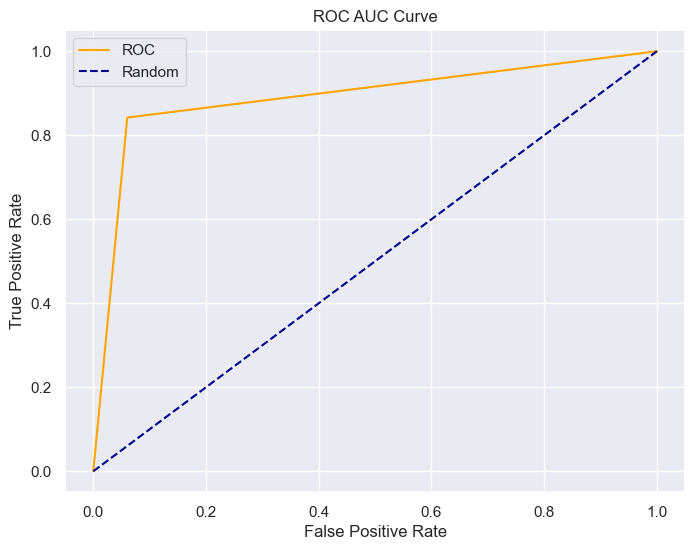

In [67]:
fpr, tpr, thresholds = roc_curve(y_test_std, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend()
plt.show()

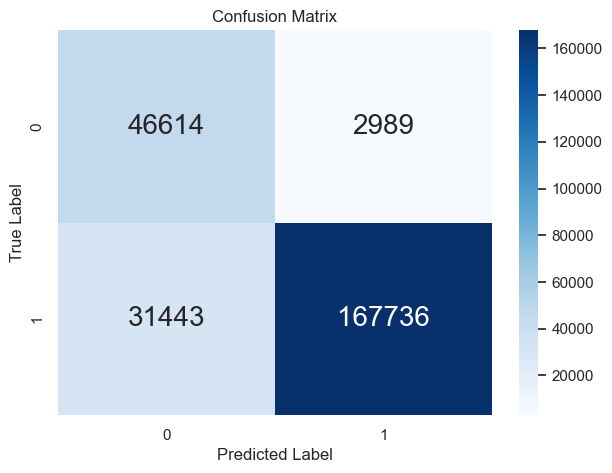

In [70]:
cm = confusion_matrix(y_test_std, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 20})
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [71]:
# Calculate class weights
class_counts = np.bincount(y_train_std)
total_samples = len(y_train_std)
class_weights = [total_samples / (len(class_counts) * count) for count in class_counts]

# Create the CatBoostClassifier with class weights
cat_model = cb.CatBoostClassifier(
    task_type="GPU",
    verbose=False,
    class_weights=class_weights  
)

# Fit the model
cat_model.fit(X_train_std, y_train_std)

# Predict and print classification report
y_pred = cat_model.predict(X_test_std)

In [72]:
print('Precision: %.3f' % precision_score(y_test_std, y_pred))
print('Recall: %.3f' % recall_score(y_test_std, y_pred))
print('ROC AUC: %.3f' % roc_auc_score(y_test_std, y_pred))

Precision: 0.985
Recall: 0.827
ROC AUC: 0.888


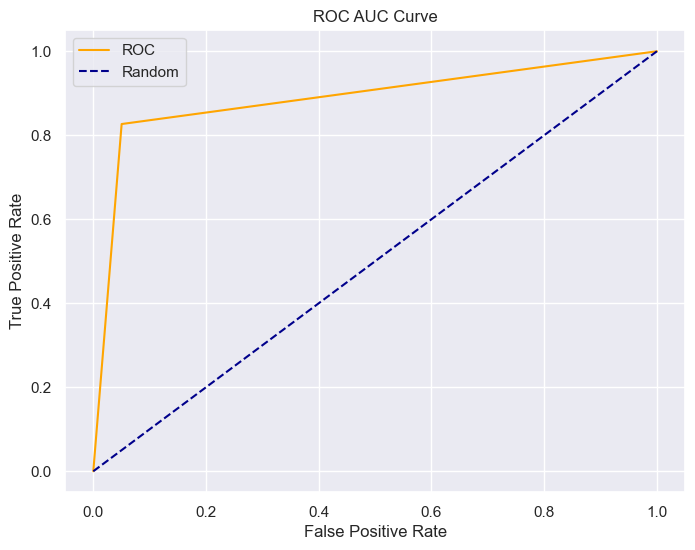

In [74]:
fpr, tpr, thresholds = roc_curve(y_test_std, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend()
plt.show()

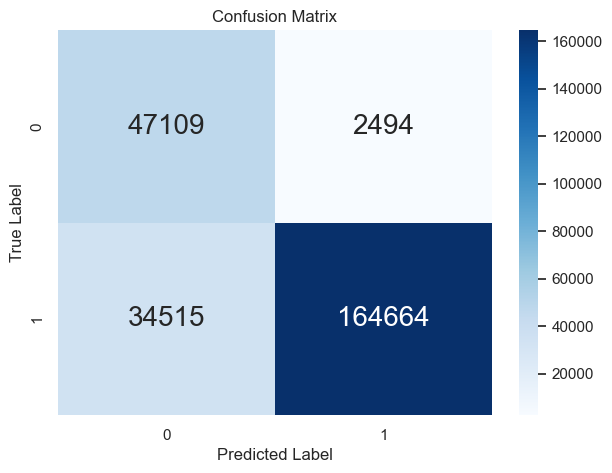

In [75]:
cm = confusion_matrix(y_test_std, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 20})
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Hyperparameter Tuning

In [78]:
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }
    
    model = xgb.XGBClassifier(**params, tree_method='gpu_hist', gpu_id=0, scale_pos_weight=imbalance_ratio)
    model.fit(X_train_std, y_train_std)
    
    y_pred = model.predict(X_test_std)
    
    # Calculate roc auc score as the objective to optimize
    roc_auc = roc_auc_score(y_test_std, y_pred)
    return roc_auc

In [79]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  

best_params = study.best_params
best_roc_auc = study.best_value
print("Best Hyperparameters:", best_params)
print("Best ROC AUC:", best_roc_auc)

joblib.dump(study, 'xgb_study.pkl')

Best Hyperparameters: {'eta': 0.20073268385348306, 'max_depth': 10, 'subsample': 0.9502019885478856, 'colsample_bytree': 0.9311314491654397, 'min_child_weight': 7}
Best ROC AUC: 0.8930760740077904


['xgb_study.pkl']

- eta (Learning Rate):

This hyperparameter controls the step size at which the gradient boosting algorithm takes steps towards a minimum of the loss function.
A smaller value makes the learning process more robust, but may require more boosting rounds.
A larger value makes the algorithm converge faster, but it can overshoot the optimal solution.

- max_depth (Maximum Depth of a Tree):

This hyperparameter specifies the maximum depth of an individual decision tree in the ensemble.
A deeper tree can capture complex relationships in the data but can also lead to overfitting.
A smaller value helps prevent overfitting by limiting the depth of the trees.

- subsample (Subsample Ratio of the Training Data):

This hyperparameter controls the fraction of samples used for training each tree.
A value less than 1.0 introduces randomness and helps prevent overfitting by training on a subset of the data.
However, setting it too low might lead to underfitting.

- colsample_bytree (Subsample Ratio of Columns When Constructing Each Tree):

This hyperparameter controls the fraction of features (columns) used when constructing each tree.
It introduces additional randomness and helps prevent overfitting by using only a subset of features for each tree.
Like subsample, setting it too low might lead to underfitting.

- min_child_weight (Minimum Sum of Instance Weight (hessian) Needed in a Child):

This hyperparameter defines the minimum sum of instance weights required to continue splitting a node in the tree.
It can be used to control the partitioning of data based on the number of instances in a node.
A higher value can make the algorithm more conservative by avoiding splits with low instance weights.

In [80]:
xgb_optimized = xgb.XGBClassifier(eta=0.20073268385348306, max_depth=10, subsample=0.9502019885478856, colsample_bytree=0.9311314491654397,
                                  min_child_weight=7, tree_method='gpu_hist', gpu_id=0, predictor='gpu_predictor', n_estimators=1000, scale_pos_weight=imbalance_ratio
                                  )
xgb_optimized.fit(X_train_std, y_train_std)
y_pred = xgb_optimized.predict(X_test_std)

In [81]:
print('Precision: %.3f' % precision_score(y_test_std, y_pred))
print('Recall: %.3f' % recall_score(y_test_std, y_pred))
print('ROC AUC: %.3f' % roc_auc_score(y_test_std, y_pred))

Precision: 0.962
Recall: 0.901
ROC AUC: 0.879


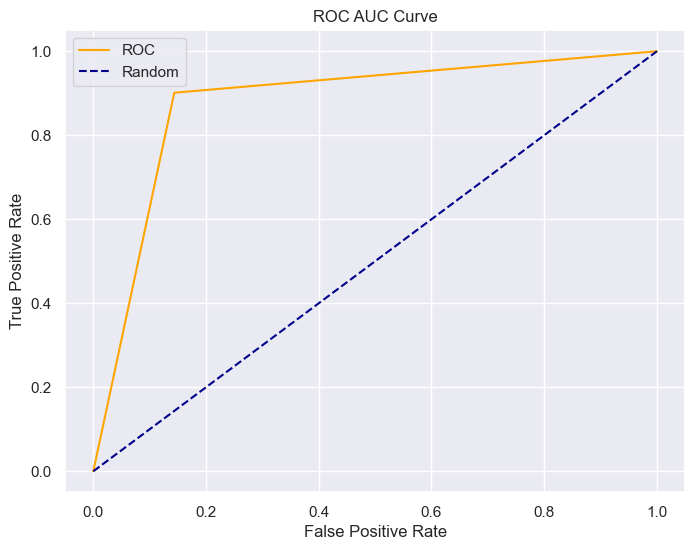

In [83]:
fpr, tpr, thresholds = roc_curve(y_test_std, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend()
plt.show()

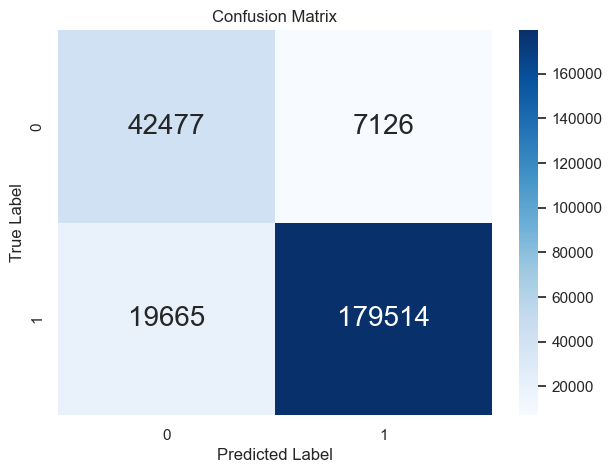

In [84]:
cm = confusion_matrix(y_test_std, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 20})
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

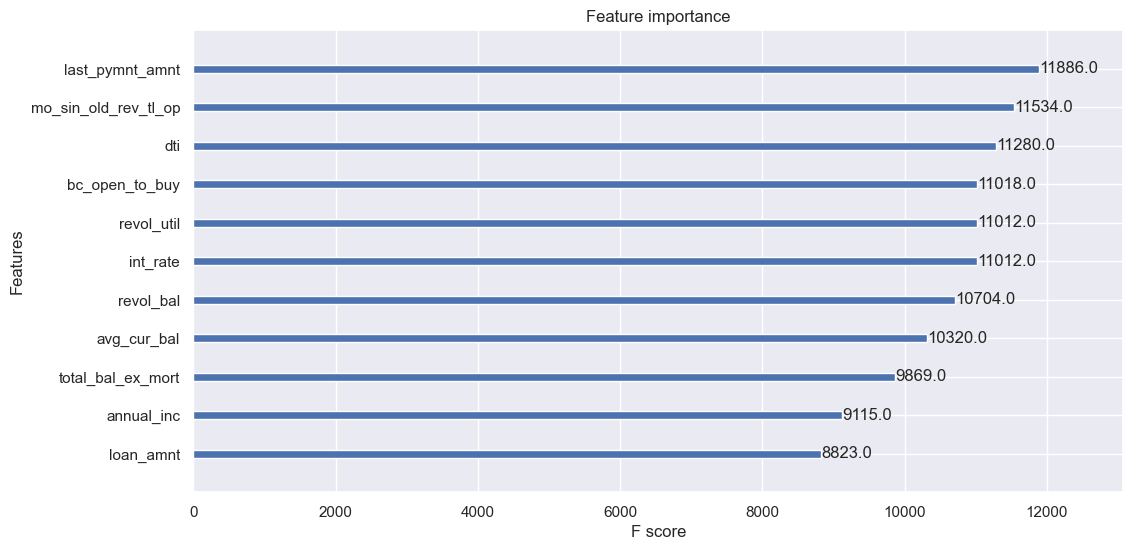

In [85]:
xgb_optimized.get_booster().feature_names = original_feature_names
xgb.plot_importance(xgb_optimized, max_num_features=11)
plt.show()

## Dimesnionality Reduction

In [37]:
batches = 100
iPca = IncrementalPCA(n_components=63, whiten=True)
for batch in np.array_split(X_train, batches):
    iPca.partial_fit(batch)

X_reduced = iPca.transform(X_train)

I have used Incremental PCA because of memory overflow.

In [38]:
cumulative_variance_ratio = np.cumsum(iPca.explained_variance_ratio_)

In [39]:
desired_threshold = 0.99
n_components = np.argmax(cumulative_variance_ratio >= desired_threshold) + 1
print(f"Number of components required to explain {desired_threshold*100}% of the variance: {n_components}")

Number of components required to explain 99.0% of the variance: 6


Now we have identifed how many components we need to do the PCA

In [40]:
batches = 100
iPca_v2 = IncrementalPCA(n_components=n_components, whiten=True)
for batch in np.array_split(X_train, batches):
    iPca_v2.partial_fit(batch)

X_reduced_v2 = iPca_v2.transform(X_train)

In [41]:
loading_vectors = iPca_v2.components_
loading_vectors = loading_vectors.T
selected_features_indices = np.argsort(np.abs(loading_vectors), axis=0)[::-1]

n_selected_features = 10
selected_features = []
for component_indicies in selected_features_indices[:n_selected_features]:
    selected_features.extend(component_indicies)

selected_features = list(set(selected_features))
selected_feature_names = X_train.columns[selected_features]
print(selected_feature_names)

Index(['loan_amnt', 'annual_inc', 'dti', 'total_bal_ex_mort', 'fico_range_low',
       'fico_range_high', 'revol_bal', 'revol_util', 'last_pymnt_amnt',
       'tot_coll_amt', 'avg_cur_bal', 'bc_open_to_buy', 'delinq_amnt',
       'mo_sin_old_rev_tl_op'],
      dtype='object')


Above we did feature selection from our PCA, these are the features that describe the higherst variance among thier components

Above we can see that the features selected by the PCA and the feature importance analysis from the XGBoost model are almost very similar, son now we can train a model based on these features once again.

In [48]:
X_smaller = X[['last_pymnt_amnt', 'dti', 'mo_sin_old_rev_tl_op', 'int_rate', 'revol_util',
               'bc_open_to_buy', 'revol_bal', 'avg_cur_bal', 'total_bal_ex_mort', 'annual_inc', 'loan_amnt']]

X_train_smaller, X_test_smaller, y_train_smaller, y_test_smaller = train_test_split(X_smaller, y, test_size=0.2, random_state=123)

In [51]:
def objective_smaller(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }
    
    model = xgb.XGBClassifier(**params, tree_method='gpu_hist', gpu_id=0, scale_pos_weight=imbalance_ratio)
    model.fit(X_train_smaller, y_train_smaller)
    
    y_pred = model.predict(X_test_smaller)
    
    recall = recall_score(y_test_smaller, y_pred)
    return recall

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective_smaller, n_trials=100)  

In [54]:
best_params = study.best_params
best_roc_auc = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Recall:", best_roc_auc)

joblib.dump(study, 'xgb_study_2.pkl')

Best Hyperparameters: {'eta': 0.2998823570610869, 'max_depth': 10, 'subsample': 0.8831355452744996, 'colsample_bytree': 0.9214193587420687, 'min_child_weight': 1}
Best Recall: 0.852520820678611


['xgb_study_2.pkl']

In [55]:
xgb_smaller = xgb.XGBClassifier(eta=0.2998823570610869, max_depth=10, subsample=0.8831355452744996, colsample_bytree=0.9214193587420687,
                                  min_child_weight=1, tree_method='gpu_hist', gpu_id=0, predictor='gpu_predictor', n_estimators=1000, scale_pos_weight=imbalance_ratio
                                  )
xgb_smaller.fit(X_train_smaller, y_train_smaller)
y_pred = xgb_smaller.predict(X_test_smaller)

In [56]:
print('Precision: %.3f' % precision_score(y_test_smaller, y_pred_smaller))
print('Recall: %.3f' % recall_score(y_test_smaller, y_pred_smaller))
print('ROC AUC: %.3f' % roc_auc_score(y_test_smaller, y_pred_smaller))

Precision: 0.982
Recall: 0.840
ROC AUC: 0.890


In [105]:
joblib.dump(X_test_smaller, 'X_test_smaller.joblib')

['X_test_smaller.joblib']

In [98]:
joblib.dump(pipeline, 'pipeline.joblib')

['pipeline.joblib']

## Clustering for Customer Segmentation

In [47]:
accepted_df['term'] = accepted_df['term'].apply(lambda x: 60 if x == ' 60 months' else 36)

Now we will Select relevant features, Filter out the data for charged off and fully paid loans, Standardize the data, Combine the data for clustering

In [57]:
features = ['loan_amnt', 'annual_inc', 'int_rate', 'term', 'dti']

charged_off_data = accepted_df[accepted_df['loan_status'] == 'Charged Off'][features]
fully_paid_data = accepted_df[accepted_df['loan_status'] == 'Fully Paid'][features]

scaler = StandardScaler()
charged_off_scaled = scaler.fit_transform(charged_off_data)
fully_paid_scaled = scaler.fit_transform(fully_paid_data)

combined_data = np.vstack((charged_off_scaled, fully_paid_scaled))

Then we will use AIC and BIC to determine what number of clusters to use and which of them provides the best performance

In [58]:
lowest_bic = np.infty
best_n_components_bic = 0

lowest_aic = np.infty
best_n_components_aic = 0

n_components_range = range(1, 11)
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(combined_data)

    bic = gmm.bic(combined_data)
    if bic < lowest_bic:
        lowest_bic = bic
        best_n_components_bic = n_components

    aic = gmm.aic(combined_data)
    if aic < lowest_aic:
        lowest_aic = aic
        best_n_components_aic = n_components

In [59]:
optimal_clusters_bic = best_n_components_bic
optimal_clusters_aic = best_n_components_aic

print("Optimal number of clusters (BIC):", optimal_clusters_bic)
print("Optimal number of clusters (AIC):", optimal_clusters_aic)

optimal_clusters = (optimal_clusters_bic + optimal_clusters_aic) // 2 
print("Optimal number of clusters:", optimal_clusters)

Optimal number of clusters (BIC): 7
Optimal number of clusters (AIC): 7
Optimal number of clusters: 7


Now we can use 7 clusters

In [60]:
num_clusters = optimal_clusters
gmm = GaussianMixture(n_components=num_clusters, random_state=42)
gmm.fit(combined_data)

charged_off_labels = gmm.predict(charged_off_scaled)
fully_paid_labels = gmm.predict(fully_paid_scaled)

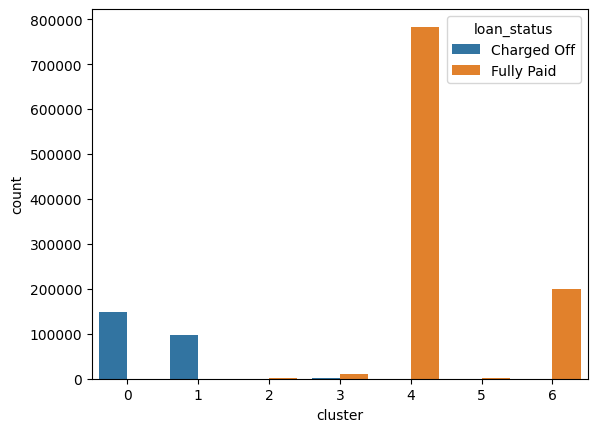

In [61]:
charged_off_clusters = pd.DataFrame({'cluster': charged_off_labels, 'loan_status': 'Charged Off'})
fully_paid_clusters = pd.DataFrame({'cluster': fully_paid_labels, 'loan_status': 'Fully Paid'})

combined_clusters = pd.concat([charged_off_clusters, fully_paid_clusters])

sns.countplot(x="cluster", hue="loan_status", data=combined_clusters)
plt.show()

In [62]:
cluster_features = pd.concat([accepted_df[features], pd.Series(gmm.predict(combined_data), name='cluster')], axis=1)
cluster_feature_means = cluster_features.groupby('cluster').mean()

print("Mean Feature Values for Each Cluster:")
print(cluster_feature_means)

Mean Feature Values for Each Cluster:
            loan_amnt    annual_inc   int_rate       term        dti
cluster                                                             
0.0      14608.879358  77063.375851  12.169422  41.710163  18.972184
1.0      14651.058231  77656.318264  12.174728  41.728295  18.963024
2.0      14517.505924  77900.241943  13.012488  41.317536  18.406754
3.0      14540.130808  76338.497773  12.808299  41.913315  18.936602
4.0      14648.465354  76997.814563  12.950100  41.767955  18.863450
5.0      14471.224832  76347.956421  13.031924  41.476510  18.927170
6.0      14620.134573  77240.793436  12.957916  41.704107  18.940824


In [63]:
cluster_feature_max = cluster_features.groupby('cluster').max()
cluster_feature_min = cluster_features.groupby('cluster').min()

print("Maximum Feature Values for Each Cluster:")
print(cluster_feature_max)

print("\nMinimum Feature Values for Each Cluster:")
print(cluster_feature_min)

Maximum Feature Values for Each Cluster:
         loan_amnt  annual_inc  int_rate  term     dti
cluster                                               
0.0        35000.0   9000000.0     28.99  60.0  999.00
1.0        35000.0   9500000.0     28.99  60.0  672.52
2.0        40000.0    721000.0     30.99  60.0   43.84
3.0        40000.0   1300000.0     30.99  60.0  170.12
4.0        40000.0   9225000.0     30.99  60.0  999.00
5.0        38400.0    400000.0     30.94  60.0   78.20
6.0        40000.0  10999200.0     30.99  60.0  999.00

Minimum Feature Values for Each Cluster:
         loan_amnt  annual_inc  int_rate  term   dti
cluster                                             
0.0         1000.0      1770.0      5.32  36.0  0.00
1.0         1000.0      1200.0      5.32  36.0  0.00
2.0         1000.0     11200.0      5.32  36.0  0.30
3.0         1000.0      3000.0      5.31  36.0  0.00
4.0         1000.0        16.0      5.31  36.0 -1.00
5.0         1000.0      6000.0      5.32  36.0  0.2

## Summary

In this notebook, an analysis of the Lending Club dataset has been undertaken, encompassing data exploration and analysis steps. The exploration included techniques such as Exploratory Data Analysis (EDA), statistical inference, and model development. Throughout these stages, valuable insights were gleaned from the data.

Furthermore, model hyperparameter tuning was performed a notable variety of hyperparameters were optimized.

Dimensionality reduction was also performed. By employing dimensionality reduction methods, the dataset's complexity was mitigated while retaining its crucial features.

Clustering was also used for a minor customer segmentation.

It's noteworthy that, due to memory constraints and hardware limitations, some potential models and their evaluations were left unexplored. However, with the prospect of improved memory resources and an enhanced GPU we could imporove some of the parts of this notebook.